In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import regex as re
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet121
from keras.models import load_model
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm
import albumentations as A
import imageio
import cv2
import os
import concurrent.futures

print("done importing")





2024-06-30 04:38:32.787253: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 04:38:32.787302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 04:38:32.788602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 04:38:32.796239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 04:38:33.498987: W tensorflow/compiler/tf2

done importing


In [4]:
'/home/professor/Downloads/fromgit/archive/images/images_normalized'

'/home/professor/Downloads/fromgit/archive/images/images_normalized'

In [5]:
reports_df = pd.read_csv('/home/professor/Downloads/fromgit/archive/indiana_reports.csv')
projections_df = pd.read_csv('/home/professor/Downloads/fromgit/archive/indiana_projections.csv')

In [6]:

reports_df.head(10)

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
5,6,normal,normal,"PA and Lateral Chest. XXXX, XXXX at XXXX",Evaluate for infection,"XXXX, XXXX",Heart size and mediastinal contour are within ...,No acute cardiopulmonary findings.
6,7,Pulmonary Atelectasis/base;Spondylosis/thoraci...,Pulmonary Atelectasis;Spondylosis;Arthritis,Xray Chest PA and Lateral,Preop lumbar surgery,"XXXX, XXXX",The cardiac contours are normal. XXXX basilar ...,Basilar atelectasis. No confluent lobar consol...
7,8,normal,normal,Xray Chest PA and Lateral,XXXX-year-old with XXXX on XXXX. Dyspnea. Hist...,Two views of the chest dated XXXX.,"The heart, pulmonary XXXX and mediastinum are ...",No acute cardiopulmonary disease.
8,9,Calcified Granuloma/lung/upper lobe/right;Dens...,Calcified Granuloma;Density,Xray Chest PA and Lateral,Chest pain today. History of stent placement 7...,"CT XXXX image XXXX, CT abdomen which included ...",The XXXX examination consists of frontal and l...,Increased size of density in the left cardioph...
9,10,Calcified Granuloma/lung/upper lobe/right,Calcified Granuloma,PA and lateral chest x-XXXX XXXX.,"XXXX-year-old male, chest pain.",Chest radiographs XXXX.,The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.


In [7]:
print(len(projections_df))
print(len(reports_df))

7466
3851


In [8]:
#counting the no.of unique patients in the dataset 
frontal_mask = projections_df['projection']=='Lateral'
df_frontal = projections_df[frontal_mask]

# Merge the filtered projections dataframe with the reports dataframe
df_merged = pd.merge(df_frontal,reports_df,on='uid')

result_dict = {row['filename']: [row['uid'], row['findings'], row['impression']] for _, row in df_merged.iterrows()}


final_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['uid', 'findings', 'impression']).reset_index()
final_df = final_df.rename(columns={'index': 'filename'})

# Display the resulting dataframe
final_df.head()


,filename,uid,findings,impression
0,1_IM-0001-3001.dcm.png,1,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2_IM-0652-2001.dcm.png,2,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3_IM-1384-2001.dcm.png,3,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4_IM-2050-2001.dcm.png,4,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5_IM-2117-1004003.dcm.png,5,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [9]:
len(final_df)
final_df.isna().sum()

filename        0
uid             0
findings      486
impression     22
dtype: int64

In [10]:
len(final_df)

3648

In [11]:
drop_mask = []
img_path = '/home/professor/Downloads/fromgit/archive/images/images_normalized'
for i in range(len(final_df)):
    final_df.iloc[i,0] = os.path.join(img_path,final_df.iloc[i,0])
    if type(final_df.iloc[i, 2]) == str:
        drop_mask.append(False)
    elif type(final_df.iloc[i, 2]) == float and type(final_df.iloc[i, 3]) != float:
        final_df.iloc[i, 2] = final_df.iloc[i, 3]
        drop_mask.append(False)
    else:
        drop_mask.append(True)

# Drop the rows where the mask is True
final_df = final_df[~pd.Series(drop_mask).values]

# Reset the index if necessary
final_df.reset_index(drop=True, inplace=True)

# Print the cleaned DataFrame
final_df.head()

,filename,uid,findings,impression
0,/home/professor/Downloads/fromgit/archive/imag...,1,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,/home/professor/Downloads/fromgit/archive/imag...,2,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,/home/professor/Downloads/fromgit/archive/imag...,3,"No displaced rib fractures, pneumothorax, or p...","No displaced rib fractures, pneumothorax, or p..."
3,/home/professor/Downloads/fromgit/archive/imag...,4,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,/home/professor/Downloads/fromgit/archive/imag...,5,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [12]:
import math
type(final_df.iloc[1,2]) == str

True

In [13]:
final_df.isnull().sum()

filename      0
uid           0
findings      0
impression    6
dtype: int64

In [14]:
len(final_df)

3632

In [15]:
aug1 = A.Compose([A.HorizontalFlip(p=1)])
aug2 = A.Compose([A.VerticalFlip(p=1)])

In [16]:
# c = 1

aug1 = A.Compose([A.HorizontalFlip(p=1)])
aug2 = A.Compose([A.VerticalFlip(p=1)])

def process_image(index, image_path, uid, findings, output_dir):
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Warning: Unable to read image at path: {image_path}")
        return []

    augmented1 = aug1(image=original_image)['image']
    augmented2 = aug2(image=original_image)['image']

    new_img_path1 = os.path.join(output_dir, f"{os.path.basename(image_path)}_aug1.png")
    new_img_path2 = os.path.join(output_dir, f"{os.path.basename(image_path)}_aug2.png")

    imageio.imwrite(new_img_path1, augmented1)
    imageio.imwrite(new_img_path2, augmented2)

    new_row1 = {'filename': new_img_path1, 'uid': uid, 'findings': findings}
    new_row2 = {'filename': new_img_path2, 'uid': uid, 'findings': findings}

    return [new_row1, new_row2]

def augment_images(final_df, output_dir, max_images=1300):
    os.makedirs(output_dir, exist_ok=True)

    # Only process the first max_images entries
    truncated_df = final_df.iloc[:max_images]

    args_list = [
        (i, truncated_df.iloc[i, 0], truncated_df.iloc[i, 1], truncated_df.iloc[i, 2], output_dir)
        for i in range(len(truncated_df))
    ]

    results = []
    c = 0
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_args = {executor.submit(process_image, *args): args for args in args_list}
        for future in concurrent.futures.as_completed(future_to_args):
            res = future.result()
            if res:
                results.extend(res)
                c += 1
                if c % 50 == 0:
                    print(c)
                if c >= max_images:
                    break

    for new_row in results:
        final_df.loc[len(final_df)] = new_row

    print(f"Processed {c * 2} images.")

A_dir = "/home/professor/Downloads/fromgit/archive/images/augdata"
augment_images(final_df, A_dir)


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
Processed 2600 images.


In [17]:
5

5

In [19]:
final_df

,filename,uid,findings,impression
0,/home/professor/Downloads/fromgit/archive/imag...,1,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,/home/professor/Downloads/fromgit/archive/imag...,2,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,/home/professor/Downloads/fromgit/archive/imag...,3,"No displaced rib fractures, pneumothorax, or p...","No displaced rib fractures, pneumothorax, or p..."
3,/home/professor/Downloads/fromgit/archive/imag...,4,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,/home/professor/Downloads/fromgit/archive/imag...,5,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
...,...,...,...,...
6227,/home/professor/Downloads/fromgit/archive/imag...,1436,The cardiac and mediastinal contours are withi...,NaN
6228,/home/professor/Downloads/fromgit/archive/imag...,1437,The heart is normal in size and contour. There...,NaN
6229,/home/professor/Downloads/fromgit/archive/imag...,1437,The heart is normal in size and contour. There...,NaN
6230,/home/professor/Downloads/fromgit/archive/imag...,1439,Lungs are XXXX. XXXX opacities are present in ...,NaN


In [20]:
final_df.iloc[6000]['filename']

'/home/professor/Downloads/fromgit/archive/images/augdata/1324_IM-0209-2001.dcm.png_aug1.png'

In [24]:
final_df.drop("impression", inplace=True, axis=1)

In [25]:
final_df

,filename,uid,findings
0,/home/professor/Downloads/fromgit/archive/imag...,1,The cardiac silhouette and mediastinum size ar...
1,/home/professor/Downloads/fromgit/archive/imag...,2,Borderline cardiomegaly. Midline sternotomy XX...
2,/home/professor/Downloads/fromgit/archive/imag...,3,"No displaced rib fractures, pneumothorax, or p..."
3,/home/professor/Downloads/fromgit/archive/imag...,4,There are diffuse bilateral interstitial and a...
4,/home/professor/Downloads/fromgit/archive/imag...,5,The cardiomediastinal silhouette and pulmonary...
...,...,...,...
6227,/home/professor/Downloads/fromgit/archive/imag...,1436,The cardiac and mediastinal contours are withi...
6228,/home/professor/Downloads/fromgit/archive/imag...,1437,The heart is normal in size and contour. There...
6229,/home/professor/Downloads/fromgit/archive/imag...,1437,The heart is normal in size and contour. There...
6230,/home/professor/Downloads/fromgit/archive/imag...,1439,Lungs are XXXX. XXXX opacities are present in ...


In [26]:

def decontracted(phrase):
  """ This function expands the contractions in the text"""


  
    # specific
  phrase = str(phrase)
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

    # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  phrase = re.sub('xxxx','',phrase) #occurs many times in text may be private information which isn't useful
  return str(phrase)

final_df['findings']= final_df['findings'].apply(decontracted)

In [27]:
def other_processing(phrase):
  """Other text processing mentioned below"""

  phrase = str(phrase)
  phrase = re.sub(r'xx*','',phrase) # Removing XXXX
  phrase = re.sub(r'\d','',phrase) # Removing numbers
  
  temp = ""

  for i in phrase.split(" "): #Removing 2 letter words
    if i!= 'no' or i!='ct':
      temp = temp + ' ' + i
    prev = i
  temp = re.sub(' {2,}', ' ',temp) #Replacing double space with single space
  temp = re.sub(r'\.+', ".", temp) #Replacing double . with single .
  temp = temp.lstrip() #Removing space at the beginning
  temp = temp.rstrip() #Removing space at the end
  return temp



final_df['findings']= final_df['findings'].apply(other_processing)

In [28]:
final_df.head()

,filename,uid,findings
0,/home/professor/Downloads/fromgit/archive/imag...,1,The cardiac silhouette and mediastinum size ar...
1,/home/professor/Downloads/fromgit/archive/imag...,2,Borderline cardiomegaly. Midline sternotomy XX...
2,/home/professor/Downloads/fromgit/archive/imag...,3,"No displaced rib fractures, pneumothora, or pl..."
3,/home/professor/Downloads/fromgit/archive/imag...,4,There are diffuse bilateral interstitial and a...
4,/home/professor/Downloads/fromgit/archive/imag...,5,The cardiomediastinal silhouette and pulmonary...


In [29]:
def count_word(sent):
  """Counts number of words in given sentence"""
  sent = str(sent)
  return len(sent.split(" "))

In [30]:
num_words = pd.DataFrame(columns=['findings'])
num_words['findings'] = final_df['findings'].apply(count_word)

In [31]:
num_words.describe(percentiles = [0.25,0.75,0.95,0.99])

,findings
count,6232.000000
mean,30.802311
std,14.805346
min,3.000000
25%,20.000000
50%,29.000000
75%,38.000000
95%,58.000000
99%,78.000000
max,149.000000


Findings for below image is : No displaced rib fractures, pneumothora, or pleural effusion identified. Well-epanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.


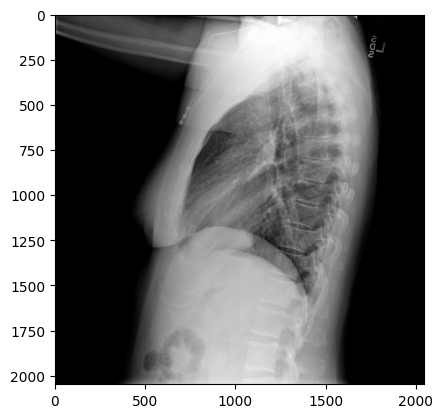

In [32]:
img_dir = img_path
print("Findings for below image is :" , final_df.at[2,'findings'])
img = cv2.imread(os.path.join(img_dir,final_df.at[2,'filename']))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

Findings for below image is : The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothora. Stable calcified granuloma within the right upper lung. No acute bone abnormality.


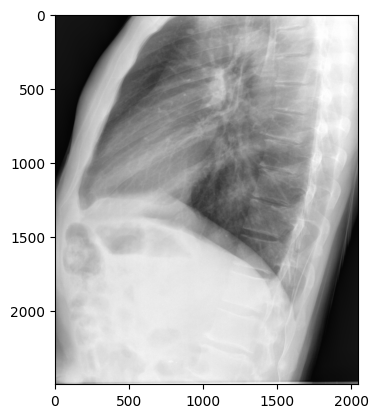

In [33]:
print("Findings for below image is :" , final_df.at[9,'findings'])
img = cv2.imread(os.path.join(img_dir,final_df.at[9,'filename']))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [3]:


chex_weights = '/home/professor/Downloads/fromgit/archive/chexweights.h5'
chexnet = DenseNet121(weights=chex_weights,                    
                      classes = 14,input_shape=(224,224,3))
model = Model(chexnet.input, chexnet.layers[-2].output)

2024-06-30 04:27:07.282837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 04:27:07.328302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 04:27:07.328607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [38]:
chexnet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [25]:
model = Model(chexnet.input, chexnet.layers[-2].output)

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [46]:
def load_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to read image at path: {image_path}")
        return None
    image = cv2.resize(image, target_size)
    image = image.astype('float32')
    image = preprocess_input(image)  # Use the appropriate preprocessing function for your model
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image


In [47]:
image_paths = final_df['filename'].astype(str).tolist()


In [48]:
import numpy as np

from tensorflow.keras.applications.resnet50 import preprocess_input  # or another preprocessing function based on your model

image_features = []

for i in tqdm(range(len(image_paths))):
    # Load image
    i1 = load_image(image_paths[i])
    
    # Predict image features
    img_features = model.predict(i1)
    
    # Convert features to float (if needed) and append to list
    img_features = img_features.astype(float)
    image_features.append(img_features)


  0%|          | 0/6232 [00:00<?, ?it/s]

2024-06-30 03:11:28.962396: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 0s 26ms/step


In [49]:
final_df['image_features'] =image_features

In [50]:
final_df

,filename,uid,findings,image_features
0,/home/professor/Downloads/fromgit/archive/imag...,1,The cardiac silhouette and mediastinum size ar...,"[[0.13362303376197815, 0.0, 0.0001036946268868..."
1,/home/professor/Downloads/fromgit/archive/imag...,2,Borderline cardiomegaly. Midline sternotomy XX...,"[[0.11984431743621826, 0.0, 0.0006720632663927..."
2,/home/professor/Downloads/fromgit/archive/imag...,3,"No displaced rib fractures, pneumothora, or pl...","[[0.12883950769901276, 0.0, 0.0003276190545875..."
3,/home/professor/Downloads/fromgit/archive/imag...,4,There are diffuse bilateral interstitial and a...,"[[0.1524106115102768, 0.0, 0.0, 0.008435610681..."
4,/home/professor/Downloads/fromgit/archive/imag...,5,The cardiomediastinal silhouette and pulmonary...,"[[0.1884971410036087, 0.0, 0.0, 0.014636723324..."
...,...,...,...,...
6227,/home/professor/Downloads/fromgit/archive/imag...,1436,The cardiac and mediastinal contours are withi...,"[[0.1376246064901352, 0.0, 0.00040378584526479..."
6228,/home/professor/Downloads/fromgit/archive/imag...,1437,The heart is normal in size and contour. There...,"[[0.13303589820861816, 0.0, 3.674633944683592e..."
6229,/home/professor/Downloads/fromgit/archive/imag...,1437,The heart is normal in size and contour. There...,"[[0.13385462760925293, 0.0, 0.0, 0.01100113429..."
6230,/home/professor/Downloads/fromgit/archive/imag...,1439,Lungs are XXXX. XXXX opacities are present in ...,"[[0.13777075707912445, 0.0, 0.0006652956362813..."


In [51]:
final_df['findings_total'] = '<start>' + ' ' + final_df.findings.astype(str) + ' ' +'<end>'
final_df['dec_ip'] = '<start>' + ' ' + final_df.findings.astype(str)  #Decoder input
final_df['dec_op'] = final_df.findings.astype(str) + ' ' +'<end>'     #dDecoder output

In [52]:
final_df

,filename,uid,findings,image_features,findings_total,dec_ip,dec_op
0,/home/professor/Downloads/fromgit/archive/imag...,1,The cardiac silhouette and mediastinum size ar...,"[[0.13362303376197815, 0.0, 0.0001036946268868...",<start> The cardiac silhouette and mediastinum...,<start> The cardiac silhouette and mediastinum...,The cardiac silhouette and mediastinum size ar...
1,/home/professor/Downloads/fromgit/archive/imag...,2,Borderline cardiomegaly. Midline sternotomy XX...,"[[0.11984431743621826, 0.0, 0.0006720632663927...",<start> Borderline cardiomegaly. Midline stern...,<start> Borderline cardiomegaly. Midline stern...,Borderline cardiomegaly. Midline sternotomy XX...
2,/home/professor/Downloads/fromgit/archive/imag...,3,"No displaced rib fractures, pneumothora, or pl...","[[0.12883950769901276, 0.0, 0.0003276190545875...","<start> No displaced rib fractures, pneumothor...","<start> No displaced rib fractures, pneumothor...","No displaced rib fractures, pneumothora, or pl..."
3,/home/professor/Downloads/fromgit/archive/imag...,4,There are diffuse bilateral interstitial and a...,"[[0.1524106115102768, 0.0, 0.0, 0.008435610681...",<start> There are diffuse bilateral interstiti...,<start> There are diffuse bilateral interstiti...,There are diffuse bilateral interstitial and a...
4,/home/professor/Downloads/fromgit/archive/imag...,5,The cardiomediastinal silhouette and pulmonary...,"[[0.1884971410036087, 0.0, 0.0, 0.014636723324...",<start> The cardiomediastinal silhouette and p...,<start> The cardiomediastinal silhouette and p...,The cardiomediastinal silhouette and pulmonary...
...,...,...,...,...,...,...,...
6227,/home/professor/Downloads/fromgit/archive/imag...,1436,The cardiac and mediastinal contours are withi...,"[[0.1376246064901352, 0.0, 0.00040378584526479...",<start> The cardiac and mediastinal contours a...,<start> The cardiac and mediastinal contours a...,The cardiac and mediastinal contours are withi...
6228,/home/professor/Downloads/fromgit/archive/imag...,1437,The heart is normal in size and contour. There...,"[[0.13303589820861816, 0.0, 3.674633944683592e...",<start> The heart is normal in size and contou...,<start> The heart is normal in size and contou...,The heart is normal in size and contour. There...
6229,/home/professor/Downloads/fromgit/archive/imag...,1437,The heart is normal in size and contour. There...,"[[0.13385462760925293, 0.0, 0.0, 0.01100113429...",<start> The heart is normal in size and contou...,<start> The heart is normal in size and contou...,The heart is normal in size and contour. There...
6230,/home/professor/Downloads/fromgit/archive/imag...,1439,Lungs are XXXX. XXXX opacities are present in ...,"[[0.13777075707912445, 0.0, 0.0006652956362813...",<start> Lungs are XXXX. XXXX opacities are pre...,<start> Lungs are XXXX. XXXX opacities are pre...,Lungs are XXXX. XXXX opacities are present in ...


In [53]:
final_df.to_pickle('final_1024.pkl') 

###LLM###

In [1]:

import tarfile
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from PIL import Image
import tensorflow as tf
import cv2 as cv
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow import concat
tf.compat.v1.enable_eager_execution()

import cv2
from skimage.transform import resize

from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,Layer,Dropout,GRU
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import repeat
from sklearn.utils import shuffle
import nltk.translate.bleu_score as bleu
import warnings
from tensorflow.keras.applications.densenet import preprocess_input

warnings.filterwarnings('ignore')


print("done importing")

2024-07-04 11:30:55.055135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 11:30:55.055188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 11:30:55.056197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 11:30:55.062273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 11:30:55.740598: W tensorflow/compiler/tf2

done importing


In [2]:
data = pd.read_pickle('final_1024.pkl')


In [3]:
len(data)


6232

In [4]:
X_train, X_test = train_test_split(data.values , test_size = 0.2 )


In [5]:
X_train.shape


(4985, 7)

In [6]:
X_test.shape


(1247, 7)

In [7]:
X_train = X_train[:-25, :]
X_test = X_test[:-31, :]


In [8]:

data.columns


Index(['filename', 'uid', 'findings', 'image_features', 'findings_total',
       'dec_ip', 'dec_op'],
      dtype='object')

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

t1 = Tokenizer( filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n',oov_token='OOV')
t1.fit_on_texts(X_train[:,4])
vocab_size_imp = len(t1.word_index) + 1

dec_inp = t1.texts_to_sequences(X_train[:,5])

dec_inp = pad_sequences(dec_inp, maxlen=76, padding='post')

dec_inp_cv = t1.texts_to_sequences(X_test[:,5])

dec_inp_cv = pad_sequences(dec_inp_cv, maxlen=76, padding='post')

dec_op = t1.texts_to_sequences(X_train[:,6])

dec_op = pad_sequences(dec_op, maxlen=76, padding='post')

dec_op_cv = t1.texts_to_sequences(X_test[:,6])

dec_op_cv = pad_sequences(dec_op_cv, maxlen=76, padding='post')


In [10]:
with open('t2.pickle', 'wb') as handle:
    pickle.dump(t1, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [11]:
vocab_size_imp


2050

In [12]:
t2 = pd.read_pickle('/home/professor/Downloads/fromgit/Deadline/t2.pickle')


In [13]:
t2 = pd.read_pickle('/home/professor/Downloads/fromgit/Deadline/t2.pickle')

imp1 = {}
imp2 = {}
for key,value in t2.word_index.items():
  imp1[value] = key
  imp2[key] = value


In [14]:
@tf.keras.utils.register_keras_serializable()

class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,units):
        super().__init__()
        self.units = units
        self.dense = Dense(self.units,name = 'Enc_dense')


    def call(self,img):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      #enc_out = self.maxpool(tf.expand_dims(img,axis = 2))
      enc_out = self.dense(img)
      return enc_out


    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.batch_size  = batch_size

      self.enc_h =tf.zeros((self.batch_size, self.units))

      #self.enc_c = tf.zeros((self.batch_size, self.lstm_size))
      return self.enc_h


In [15]:
@tf.keras.utils.register_keras_serializable()

class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,att_units):
    # Please go through the reference notebook and research paper to complete the scoring functions
    super().__init__()

    self.att_units = att_units

    self.w1 =  tf.keras.layers.Dense( self.att_units , name = 'w1')
    self.w2 =  tf.keras.layers.Dense( self.att_units,name = 'w2')
    self.v =  tf.keras.layers.Dense(1,name = 'v')
      

  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    self.decoder_hidden_state = decoder_hidden_state
    self.encoder_output = encoder_output
    print("Atten layer")
    print("Dec shape ",decoder_hidden_state.shape, "Enc shape", encoder_output.shape )
      
    # Dec shape  (32, 256) Enc shape (32, 256)



    self.decoder_hidden_state = tf.expand_dims(self.decoder_hidden_state,axis = 1)
    score = self.v(tf.nn.tanh(
              self.w1(self.decoder_hidden_state) + self.w2(self.encoder_output)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * self.encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)
    print("context vector value ",context_vector.shape, "Atten weight ", attention_weights.shape )
    return context_vector,attention_weights


In [16]:
@tf.keras.utils.register_keras_serializable()

class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units  ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.dec_emb = Embedding(tar_vocab_size,embedding_dim,trainable = True , name = 'dec_embb')
      self.dec_lstm = GRU(self.dec_units, return_state=True, return_sequences=True, name="Decoder_LSTM")
      self.dense   = Dense(self.tar_vocab_size, name = 'one_dec')
      self.attention=Attention( self.att_units)
      self.d1 = Dropout(0.3,name = 'd1')
      self.d2 = Dropout(0.3,name = 'd2')
      self.d3 = Dropout(0.3,name = 'd3')
      print("Embedding Dim ====>",embedding_dim )
      

  @tf.function
  def call(self,input_to_decoder, encoder_output, state_h):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    self.input_to_decoder = input_to_decoder
    self.encoder_output = encoder_output
    self.state_h = state_h

    #A
    target_embedd           = self.dec_emb (self.input_to_decoder)     #(batch_size,1,embedingdim)
    #B
    target_embedd = self.d1(target_embedd)

    context_vector,attention_weights=self.attention(self.state_h,self.encoder_output) #context vector shape = (batch_size,att_units)
    #C
    concated = tf.concat([  tf.expand_dims(context_vector, 1),target_embedd], -1)
    concated = self.d2(concated)

    #D
    lstm_output, hs      = self.dec_lstm(concated, initial_state=self.state_h)

    lstm_output = tf.reshape(lstm_output, (-1, lstm_output.shape[2]))
    lstm_output = self.d3(lstm_output)
    #E
    op = self.dense(lstm_output)
    #op = tf.squeeze(op,[1])
    print("ONestepDecoder ==============")
    print("input_to_decoder :- ", input_to_decoder.shape , "state_h :- ", state_h.shape)
    
    print("encoder_output ===> ", state_h.shape, "Target eMBEDING ",target_embedd.shape )
    print("Concat :- ", concated.shape)
    print("Lstm output",lstm_output.shape, "OP", op.shape )
    print("HS:- ", hs.shape)
    # print("dec_lstm:- ", dec_lstm)
    return op,hs,attention_weights,context_vector


In [17]:
@tf.keras.utils.register_keras_serializable()

class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.onestep = OneStepDecoder(self.out_vocab_size,self.embedding_dim ,self.input_length,self.dec_units,self.att_units)
      print("Decoder :- ==> ")

    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state):


        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook

        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array

        all_outputs = tf.TensorArray(tf.float32,size =input_to_decoder.shape[1],name = 'output_arrays' )
        self.input_to_decoder = input_to_decoder
        self.encoder_output = encoder_output
        self.decoder_hidden_state = decoder_hidden_state

        for timestep in tf.range(input_to_decoder.shape[1]):
          op,hs,attention_weights,context_vector = self.onestep(self.input_to_decoder[:,timestep:timestep+1], self.encoder_output, self.decoder_hidden_state)
          self.decoder_hidden_state = hs
          all_outputs = all_outputs.write(timestep,op)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])

        print("input_to_decoder" , input_to_decoder.shape)
        print("decoder_hidden_state", decoder_hidden_state.shape)
        print("all_outputs", all_outputs.shape)
        
        
        return all_outputs


In [18]:
@tf.keras.utils.register_keras_serializable()
class encoder_decoder(tf.keras.Model):
  #def __init__(self,#params):
    #Intialize objects from encoder decoder
  def __init__(self,out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size,units):

        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'

        super().__init__()

        self.units = units
        self.out_vocab_size = out_vocab_size
        self.embedding_size_d = embedding_size_d
        self.lstm_size_d = lstm_size_d
        self.input_length_d = input_length_d
        self.batch_size = batch_size
        self.att_units = att_units

        self.encoder = Encoder(self.units)

        self.decoder = Decoder(out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units )
        #self.dense   = TimeDistributed(Dense(self.out_vocab_size, activation='softmax'))
        self.dense   = Dense(self.out_vocab_size,name = 'enc_dec_dense')



  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    self.inputs,self.outputs = data[0], data[1]
    print("Data[0] value", data[0], "Data[1] value = ", data[1])
    print("="*20, "ENCODER", "="*20)
    self.encoder_h= self.encoder.initialize_states(self.batch_size)
    self.encoder_output = self.encoder(self.inputs)
    print("-"*27)
    print("ENCODER ==> OUTPUT SHAPE",self.encoder_output.shape)
    print("ENCODER ==> HIDDEN STATE SHAPE",self.encoder_h.shape)
    print("="*20, "DECODER", "="*20)
    output= self.decoder(self.outputs,self.encoder_output,self.encoder_h)
    print("-"*27)
    print("FINAL OUTPUT SHAPE",output.shape)
    print("="*50)
    return output


In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
  #out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size)


2024-07-04 11:31:11.345052: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-04 11:31:11.345085: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: professor-Aspire-A715-42G
2024-07-04 11:31:11.345092: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: professor-Aspire-A715-42G
2024-07-04 11:31:11.345300: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.183.1
2024-07-04 11:31:11.345320: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.183.1
2024-07-04 11:31:11.345325: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.183.1


In [20]:
!mkdir checkpoint


mkdir: cannot create directory ‘checkpoint’: File exists


In [21]:
import os
import tensorflow as tf

# Define current working directory
cwd = os.getcwd()

# Define checkpoint directory and file path
checkpoint_dir = os.path.join(cwd, 'checkpoint')
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint.keras')

# Ensure the checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# Create the ModelCheckpoint callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    verbose=1,
    mode='min',
    save_best_only=True
)

# Print checkpoint filepath to verify
print("Checkpoint filepath:", checkpoint_filepath)



Checkpoint filepath: /home/professor/Downloads/fromgit/Deadline/checkpoint/model_checkpoint.keras


In [22]:
tf.keras.backend.clear_session()


In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,mode = 'min',verbose = 1,
                              patience=2, min_lr=0.0001)


In [24]:
model_1 = encoder_decoder(vocab_size_imp,300,76,256,64,32,256)
optimizer = tf.keras.optimizers.Adam()
model_1.compile(optimizer=optimizer,loss=loss_function, metrics = ["accuracy"])


Embedding Dim ====> 300
Decoder :- ==> 


In [25]:
train_inp = np.vstack(X_train[:,3]).astype(float)  # Use np.float64 for double-precision floats
test_inp = np.vstack(X_test[:,3]).astype(float)  # Use np.float32 for single-precision floats (if memory efficiency is a concern)


In [26]:
# Print the shapes of your data
print("train_inp shape:", train_inp.shape)
print("dec_inp shape:", dec_inp.shape)
print("dec_op shape:", dec_op.shape)
print("test_inp shape:", test_inp.shape)
print("dec_inp_cv shape:", dec_inp_cv.shape)
print("dec_op_cv shape:", dec_op_cv.shape)


train_inp shape: (4960, 1024)
dec_inp shape: (4960, 76)
dec_op shape: (4960, 76)
test_inp shape: (1216, 1024)
dec_inp_cv shape: (1216, 76)
dec_op_cv shape: (1216, 76)


In [27]:
model_1.fit([train_inp,dec_inp ],dec_op ,validation_data= ([test_inp, dec_inp_cv],dec_op_cv),batch_size= 32,epochs  = 50,callbacks=[reduce_lr,model_checkpoint_callback] , shuffle=True)


Epoch 1/50
Data[0] value Tensor("IteratorGetNext:0", shape=(32, 1024), dtype=float32) Data[1] value =  Tensor("IteratorGetNext:1", shape=(32, 76), dtype=int32)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (32, 256)
ENCODER ==> HIDDEN STATE SHAPE (32, 256)
==================== DECODER ====================
Atten layer
Dec shape  (32, 256) Enc shape (32, 256)
context vector value  (32, 256) Atten weight  (32, 32, 1)
ONestepDecoder ==============
input_to_decoder :-  (32, None) state_h :-  (32, 256)
encoder_output ===>  (32, 256) Target eMBEDING  (32, None, 300)
Concat :-  (32, 1, 556)
Lstm output (32, 256) OP (32, 2050)
HS:-  (32, 256)
Atten layer
Dec shape  (32, 256) Enc shape (32, 256)
context vector value  (32, 256) Atten weight  (32, 32, 1)
ONestepDecoder ==============
input_to_decoder :-  (32, None) state_h :-  (32, 256)
encoder_output ===>  (32, 256) Target eMBEDING  (32, None, 300)
Concat :-  (32, 1, 556)
Lstm output (32, 2

In [28]:
# model_1.fit([train_inp,dec_inp ],dec_op ,validation_data= ([test_inp, dec_inp_cv],dec_op_cv),batch_size= 32,epochs  = 1,callbacks=[reduce_lr,model_checkpoint_callback] , shuffle=True)


In [30]:
model_1.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  262400    
                                                                 
 decoder (Decoder)           multiple                  1799963   
                                                                 
 enc_dec_dense (Dense)       multiple                  0 (unused)
                                                                 
Total params: 2062363 (7.87 MB)
Trainable params: 2062363 (7.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
#https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/
#https://github.com/vysakh10/Medical-Report-Generation-using-Deep-Learning/blob/master/Attention_Onestep_Mod.ipynb
def beam(sentence):
  """ Thi function predicts the sentence using beam search """

  initial_state=model_1.layers[0].initialize_states(1)
  encoder_output= model_1.layers[0](sentence)
  result = ''

  sequences = [['<start>' ,initial_state, 0]]

  decoder_hidden_state = initial_state

  #cur_vec = np.ones((1, 1)) * imp2['<start>']
  #cur_vec = np.array([[1]])
  finished_seq = []
  beam_width = 3

  for i in range(76):
    all_candidates = []
    new_seq = []
    for s in sequences:

      cur_vec = np.reshape(imp2[s[0].split(" ")[-1]],(1,1))
      decoder_hidden_state = s[1]
      op,hs,attention_weights,context_vector = model_1.layers[1].onestep(cur_vec, encoder_output, decoder_hidden_state)
      op = tf.nn.softmax(op)
      top3 = np.argsort(op).flatten()[-beam_width:]
      for t in top3:

         candidates = [s[0] + ' '+ imp1[t], hs,s[2]-np.log(np.array(op).flatten()[t])]
         all_candidates.append(candidates)
    sequences = sorted(all_candidates, key = lambda l: l[2])[:beam_width]

    count = 0
    for s1 in sequences:
      if s1[0].split(" ")[-1] == '<end>':


        s1[2] = s1[2]/len(s1[0])   # normalized
        finished_seq.append([s1[0], s1[1],s1[2]])
        count+=1
      else:

        new_seq.append([s1[0], s1[1],s1[2]])

    beam_width -= count
    sequences = new_seq
    if not sequences:
      break
    else:
      continue

  if len(finished_seq) >0:
    sequences = finished_seq[-1]
    return sequences[0]
  else:
    return new_seq[-1][0]


In [38]:
num = 50 #random test sample
im_o = np.vstack(X_test[:,3][num]).astype(float)
tex_o = X_test[:,4][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
# img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)
# img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)


Original Sentence is :  <start> Normal heart size. Normal pulmonary vasculature. Normal mediastinal contours. Lung parenchyma is clear. No airspace disease. No pulmonary edema. No XXXX of pleural effusions. No XXXX of active tuberculosis. No XXXX of active cardiopulmonary disease. <end>
Predicted Sentence is :  <start> the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothora. osseous structures are within normal limits for patient age. <end>


In [36]:
num = 10 #random test sample
im_o = np.vstack(X_test[:,3][num]).astype(float)
tex_o = X_test[:,4][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
# img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)
# img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)


Original Sentence is :  <start> Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact. <end>
Predicted Sentence is :  <start> the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothora. osseous structures are within normal limits for patient age. <end>


In [39]:
unique_captions = set()

# Iterate over the test data
for i in tqdm(range(len(X_test))):
    # Get the image features
    im_o = np.array(X_test[:, 3][i]).astype(float)
    
    # Predict the caption
    predicted_caption = beam(im_o)
    
    # Add the predicted caption to the set of unique captions
    unique_captions.add(predicted_caption)

# Print the count of unique captions
print("Number of unique captions:", len(unique_captions))


  0%|          | 0/1216 [00:00<?, ?it/s]

Number of unique captions: 5


In [52]:
import nltk.translate.bleu_score as bleu

#https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
b1 = 0
b2 = 0
b3 = 0
b4 = 0


for i in tqdm(range(len(X_test))):
  im_o = np.vstack(X_test[:,3][i]).astype(float)
  pred = beam(im_o)
  org= X_test[:,4][i]




  b1 =  b1 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(1, 0, 0, 0))
  b2 =  b2 + bleu.sentence_bleu([org.split()], pred.split(),weights=(0.5, 0.5, 0, 0))
  b3 =  b3 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.33, 0.33, 0.33, 0))
  b4 =  b4 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.25, 0.25, 0.25, 0.25))



print("Bleu1 score is : ",b1/X_test.shape[0])
print("Bleu2 score is : ",b2/X_test.shape[0])
print("Bleu3 score is : ",b3/X_test.shape[0])
print("Bleu4 score is : ",b4/X_test.shape[0])


  0%|          | 0/1216 [00:00<?, ?it/s]

Bleu1 score is :  0.2508601443498543
Bleu2 score is :  0.10671765028611835
Bleu3 score is :  0.04734011754471286
Bleu4 score is :  0.019411016048046372


In [10]:
checkpoint_filepath = '/home/professor/Downloads/fromgit/Deadline/checkpoint/model_checkpoint.keras'


In [12]:

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
  #out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size)


In [35]:
model_1_loaded = tf.keras.models.load_model(checkpoint_filepath, custom_objects={'loss_function': loss_function})


Embedding Dim ====> 300
Decoder :- ==> 
Data[0] value Tensor("Placeholder:0", shape=(32, 1024), dtype=float32) Data[1] value =  Tensor("Placeholder_1:0", shape=(32, 76), dtype=float32)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (32, 256)
ENCODER ==> HIDDEN STATE SHAPE (32, 256)
==================== DECODER ====================
Atten layer
Dec shape  (32, 256) Enc shape (32, 256)
context vector value  (32, 256) Atten weight  (32, 32, 1)
ONestepDecoder ==============
input_to_decoder :-  (32, None) state_h :-  (32, 256)
encoder_output ===>  (32, 256) Target eMBEDING  (32, None, 300)
Concat :-  (32, 1, 556)
Lstm output (32, 256) OP (32, 2078)
HS:-  (32, 256)
Atten layer
Dec shape  (32, 256) Enc shape (32, 256)
context vector value  (32, 256) Atten weight  (32, 32, 1)
ONestepDecoder ==============
input_to_decoder :-  (32, None) state_h :-  (32, 256)
encoder_output ===>  (32, 256) Target eMBEDING  (32, None, 300)
Concat :-  (32, 1

In [161]:
test_inp = np.array([np.array(x) for x in X_test[:, 3]]).astype(float)  # Ensure it's a 2D array of the appropriate type


In [162]:
def beam(sentence):
    """This function predicts the sentence using beam search"""
    
    initial_state = model_1_loaded.layers[0].initialize_states(1)
    encoder_output = model_1_loaded.layers[0](sentence)
    result = ''
    
    sequences = [['<start>', initial_state, 0]]
    
    decoder_hidden_state = initial_state
    
    finished_seq = []
    beam_width = 3
    
    for i in range(76):
        all_candidates = []
        new_seq = []
        for s in sequences:
            
            cur_vec = np.reshape(imp2[s[0].split(" ")[-1]], (1, 1))
            decoder_hidden_state = s[1]
            op, hs, attention_weights, context_vector = model_1_loaded.layers[1].onestep(cur_vec, encoder_output, decoder_hidden_state)
            op = tf.nn.softmax(op)
            top3 = np.argsort(op).flatten()[-beam_width:]
            for t in top3:
                
                candidates = [s[0] + ' ' + imp1[t], hs, s[2] - np.log(np.array(op).flatten()[t])]
                all_candidates.append(candidates)
        sequences = sorted(all_candidates, key=lambda l: l[2])[:beam_width]
        
        count = 0
        for s1 in sequences:
            if s1[0].split(" ")[-1] == '<end>':
                s1[2] = s1[2] / len(s1[0])  # normalized
                finished_seq.append([s1[0], s1[1], s1[2]])
                count += 1
            else:
                new_seq.append([s1[0], s1[1], s1[2]])
        
        beam_width -= count
        sequences = new_seq
        if not sequences:
            break
        else:
            continue
    
    if len(finished_seq) > 0:
        sequences = finished_seq[-1]
        return sequences[0]
    else:
        return new_seq[-1][0]


In [163]:
num = 16  # random test sample
im_o = np.array(test_inp[num]).astype(float).reshape(1, -1)
tex_o = X_test[num, 4]

print("Original Sentence is: ", tex_o)
print("Predicted Sentence is: ", beam(im_o))


Original Sentence is:  <start> Cardiac and mediastinal contours are within normal limits. The lungs are clear. Left aillary surgical clips. Bony structures are intact. <end>
Predicted Sentence is:  <start> the heart the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet121
from keras.models import load_model
from tensorflow.keras.models import Model


import os
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,Layer,Dropout,GRU


print("done importing")





2024-07-05 05:17:50.560786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 05:17:50.560879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 05:17:50.585953: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-05 05:17:50.644073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-05 05:17:51.543112: W tensorflow/compiler/tf2

done importing


In [2]:
# @tf.keras.utils.register_keras_serializable()

class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,units):
        super().__init__()
        self.units = units
        self.dense = Dense(self.units,name = 'Enc_dense')


    def call(self,img):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      #enc_out = self.maxpool(tf.expand_dims(img,axis = 2))
      enc_out = self.dense(img)
      return enc_out


    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.batch_size  = batch_size

      self.enc_h =tf.zeros((self.batch_size, self.units))

      #self.enc_c = tf.zeros((self.batch_size, self.lstm_size))
      return self.enc_h


In [3]:
# @tf.keras.utils.register_keras_serializable()

class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,att_units):
    # Please go through the reference notebook and research paper to complete the scoring functions
    super().__init__()

    self.att_units = att_units

    self.w1 =  tf.keras.layers.Dense( self.att_units , name = 'w1')
    self.w2 =  tf.keras.layers.Dense( self.att_units,name = 'w2')
    self.v =  tf.keras.layers.Dense(1,name = 'v')

  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    self.decoder_hidden_state = decoder_hidden_state
    self.encoder_output = encoder_output


    self.decoder_hidden_state = tf.expand_dims(self.decoder_hidden_state,axis = 1)
    score = self.v(tf.nn.tanh(
              self.w1(self.decoder_hidden_state) + self.w2(self.encoder_output)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * self.encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector,attention_weights


# @tf.keras.utils.register_keras_serializable()

class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units  ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.dec_emb = Embedding(tar_vocab_size,embedding_dim,trainable = True , name = 'dec_embb')
      self.dec_lstm = GRU(self.dec_units, return_state=True, return_sequences=True, name="Decoder_LSTM")
      self.dense   = Dense(self.tar_vocab_size, name = 'one_dec')
      self.attention=Attention( self.att_units)
      self.d1 = Dropout(0.3,name = 'd1')
      self.d2 = Dropout(0.3,name = 'd2')
      self.d3 = Dropout(0.3,name = 'd3')

  @tf.function
  def call(self,input_to_decoder, encoder_output, state_h):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    self.input_to_decoder = input_to_decoder
    self.encoder_output = encoder_output
    self.state_h = state_h

    #A
    target_embedd           = self.dec_emb (self.input_to_decoder)     #(batch_size,1,embedingdim)
    #B
    target_embedd = self.d1(target_embedd)

    context_vector,attention_weights=self.attention(self.state_h,self.encoder_output) #context vector shape = (batch_size,att_units)
    #C
    concated = tf.concat([  tf.expand_dims(context_vector, 1),target_embedd], -1)
    concated = self.d2(concated)

    #D
    lstm_output, hs      = self.dec_lstm(concated, initial_state=self.state_h)

    lstm_output = tf.reshape(lstm_output, (-1, lstm_output.shape[2]))
    lstm_output = self.d3(lstm_output)
    #E
    op = self.dense(lstm_output)
    #op = tf.squeeze(op,[1])
    return op,hs,attention_weights,context_vector

# @tf.keras.utils.register_keras_serializable()
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.onestep = OneStepDecoder(self.out_vocab_size,self.embedding_dim ,self.input_length,self.dec_units,self.att_units)

    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state):


        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook

        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array

        all_outputs = tf.TensorArray(tf.float32,size =input_to_decoder.shape[1],name = 'output_arrays' )
        self.input_to_decoder = input_to_decoder
        self.encoder_output = encoder_output
        self.decoder_hidden_state = decoder_hidden_state

        for timestep in tf.range(input_to_decoder.shape[1]):
          op,hs,attention_weights,context_vector = self.onestep(self.input_to_decoder[:,timestep:timestep+1], self.encoder_output, self.decoder_hidden_state)
          self.decoder_hidden_state = hs
          all_outputs = all_outputs.write(timestep,op)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs


# @tf.keras.utils.register_keras_serializable()
class encoder_decoder(tf.keras.Model):
  #def __init__(self,#params):
    #Intialize objects from encoder decoder
  def __init__(self,out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size,units):

        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'

        super().__init__()

        self.units = units
        self.out_vocab_size = out_vocab_size
        self.embedding_size_d = embedding_size_d
        self.lstm_size_d = lstm_size_d
        self.input_length_d = input_length_d
        self.batch_size = batch_size
        self.att_units = att_units

        self.encoder = Encoder(self.units)

        self.decoder = Decoder(out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units )
        #self.dense   = TimeDistributed(Dense(self.out_vocab_size, activation='softmax'))
        self.dense   = Dense(self.out_vocab_size,name = 'enc_dec_dense')



  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    self.inputs,self.outputs = data[0], data[1]
    print("="*20, "ENCODER", "="*20)
    self.encoder_h= self.encoder.initialize_states(self.batch_size)
    self.encoder_output = self.encoder(self.inputs)
    print("-"*27)
    print("ENCODER ==> OUTPUT SHAPE",self.encoder_output.shape)
    print("ENCODER ==> HIDDEN STATE SHAPE",self.encoder_h.shape)
    print("="*20, "DECODER", "="*20)
    output= self.decoder(self.outputs,self.encoder_output,self.encoder_h)
    print("-"*27)
    print("FINAL OUTPUT SHAPE",output.shape)
    print("="*50)
    return output


In [4]:
from tensorflow.keras.preprocessing import image as keras_image
t2 = pd.read_pickle('/home/professor/Downloads/fromgit/Deadline/t2.pickle')

imp1 = {}
imp2 = {}
for key,value in t2.word_index.items():
  imp1[value] = key
  imp2[key] = value


In [5]:


chex_weights = '/home/professor/Downloads/fromgit/archive/chexweights.h5'
chexnet = DenseNet121(weights='/home/professor/Downloads/fromgit/archive/chexweights.h5',                    
                      classes = 14,input_shape=(224,224,3))
model = Model(chexnet.input, chexnet.layers[-2].output)

2024-07-05 05:17:54.394502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-05 05:17:54.549075: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-05 05:17:54.549365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
checkpoint_filepath = '/home/professor/Downloads/fromgit/Deadline/checkpoint/model_checkpointG.keras'

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
  #out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size)
model_1_loaded = tf.keras.models.load_model(checkpoint_filepath, custom_objects={'loss_function': loss_function})


TypeError: Could not locate class 'encoder_decoder'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'encoder_decoder', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'encoder_decoder', 'build_config': {'input_shape': [[50, 2048], [50, 76]]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'builtins', 'class_name': 'function', 'config': 'loss_function', 'registered_name': 'function'}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}

In [46]:
def load_and_preprocess_image(image_path):
    img = keras_image.load_img(image_path, target_size=(224, 224))  
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features


In [47]:
def beam(sentence):
    """This function predicts the sentence using beam search"""
    initial_state = model_1_loaded.layers[0].initialize_states(1)
    encoder_output = model_1_loaded.layers[0](sentence)
    result = ''
    sequences = [['<start>', initial_state, 0]]
    decoder_hidden_state = initial_state
    finished_seq = []
    beam_width = 3
    for i in range(79):
        all_candidates = []
        new_seq = []
        for s in sequences:
            cur_vec = np.reshape(imp2[s[0].split(" ")[-1]], (1, 1))
            decoder_hidden_state = s[1]
            op, hs, attention_weights, context_vector = model_1_loaded.layers[1].onestep(cur_vec, encoder_output, decoder_hidden_state)
            op = tf.nn.softmax(op)
            top3 = np.argsort(op).flatten()[-beam_width:]
            for t in top3:
                candidates = [s[0] + ' ' + imp1[t], hs, s[2] - np.log(np.array(op).flatten()[t])]
                all_candidates.append(candidates)
        sequences = sorted(all_candidates, key=lambda l: l[2])[:beam_width]
        count = 0
        for s1 in sequences:
            if s1[0].split(" ")[-1] == '<end>':
                s1[2] = s1[2] / len(s1[0])  # normalized
                finished_seq.append([s1[0], s1[1], s1[2]])
                count += 1
            else:
                new_seq.append([s1[0], s1[1], s1[2]])
        beam_width -= count
        sequences = new_seq
        if not sequences:
            break
        else:
            continue
    if len(finished_seq) > 0:
        sequences = finished_seq[-1]
        return sequences[0]
    else:
        return new_seq[-1][0]


In [48]:
def predict_caption_for_image(image_path):
    img_features = load_and_preprocess_image(image_path)
    prediction = beam(img_features)
    print("Predicted Sentence is: ", prediction)

# Test the function with an example image path
example_image_path = "/home/professor/Downloads/fromgit/archive/images/images_normalized/2_IM-0652-1001.dcm.png"  # Replace with the actual image path
predict_caption_for_image(example_image_path)


1/1 [==============================] - 1s 1s/step
Predicted Sentence is:  <start> the heart is or in osseous the changes is unremarkable. the lungs are clear disease. xxxx. of pneumonia. xxxx is no pneumothora normal effusion. <end>


In [ ]:
0 filename
1 uid
2 findings
3 img-feat ====> train inp
4fing total
5dec inp
6dec out

In [32]:
print(tf.__version__)


2.15.0


In [37]:
tf.__version__

'2.15.0'